# Alphalens Quickstart Template

In [5]:
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.data import factset, USEquityPricing
from quantopian.pipeline.classifiers.fundamentals import Sector
from quantopian.pipeline.factors import Returns, SimpleMovingAverage, CustomFactor, RSI

from alphalens.performance import mean_information_coefficient
from alphalens.utils import get_clean_factor_and_forward_returns
from alphalens.tears import create_information_tear_sheet, create_returns_tear_sheet

from quantopian.pipeline.experimental import risk_loading_pipeline
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.data.psychsignal import stocktwits
from quantopian.pipeline.data import Fundamentals
import quantopian.pipeline.data.factset.estimates as fe
from quantopian.pipeline.factors import Returns
from quantopian.pipeline.data.factset.estimates import PeriodicConsensus

/venvs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:14: ZiplineDeprecationWarning: PsychSignal datasets stopped updating on Quantopian on May 1, 2020.
PsychSignal data prior to May 2020 is still available for use on Quantopian;
however, the dataset has stopped updating. For more information see:
https://www.quantopian.com/posts/psychsignal-trader-mood-update

  


## Define Your Alpha Factor Here

Spend your time in this cell, creating good factors. Then simply run the rest of the notebook to analyze `factor_to_analyze`!

In [10]:
def make_pipeline():
    
    fe_rec = fe.ConsensusRecommendations  # 5

    pe_ratio = Fundamentals.forward_pe_ratio.latest  # 4

    sentiment_score = SimpleMovingAverage(  # 3
        inputs=[stocktwits.bullish_intensity],
        window_length=5,
    )
    mean_close_10 = SimpleMovingAverage(
        inputs=[USEquityPricing.close],
        window_length=10
    )
    mean_close_30 = SimpleMovingAverage(
        inputs=[USEquityPricing.close],
        window_length=30
    )
    percent_difference = (mean_close_10 - mean_close_30) / mean_close_30

    # We winsorize our factor values in order to lessen the impact of outliers
    # For more information on winsorization, please see
    # https://en.wikipedia.org/wiki/Winsorizing
    pe_ratio_winsorized = pe_ratio.winsorize(min_percentile=0.05, max_percentile=0.95)
    sentiment_score_winsorized = sentiment_score.winsorize(
        min_percentile=0.05,
        max_percentile=0.95
    )

    percent_difference_winsorized = percent_difference.winsorize(  # 2
        min_percentile=0.1,
        max_percentile=0.9
    )

    recent_returns = Returns(window_length=5)  # 6

    fq1_eps_cons = PeriodicConsensus.slice('EPS', 'qf', 1)  # 1
    fq2_eps_cons = PeriodicConsensus.slice('EPS', 'qf', 2)

    fq1_eps_mean = fq1_eps_cons.mean.latest
    fq2_eps_mean = fq2_eps_cons.mean.latest

    estimated_growth_factor = (fq2_eps_mean - fq1_eps_mean) / fq1_eps_mean

    estimated_growth_factor_windsorized = estimated_growth_factor.winsorize(min_percentile=0.01, max_percentile=0.99)

    # Here we combine our winsorized factors, z-scoring them to equalize their influence
    combined_factor = (
            0.01 * fe_rec.total.latest +
            pe_ratio_winsorized.zscore() +
            sentiment_score_winsorized.zscore() +
            0.005 * percent_difference_winsorized.zscore() +
            0.01 * recent_returns.zscore() +
            estimated_growth_factor_windsorized.zscore()
    )
    
    #assets_moving_average = SimpleMovingAverage(inputs=[factset.Fundamentals.assets], window_length=252)
    #current_assets = factset.Fundamentals.assets.latest
    
    factor_to_analyze = combined_factor
    
    sector = Sector()
    
    return Pipeline(
        columns = {'factor_to_analyze': factor_to_analyze, 'sector': sector},
        screen = QTradableStocksUS() & factor_to_analyze.notnull() & sector.notnull()
    )

factor_data = run_pipeline(make_pipeline(), '2017-4-29', '2019-4-29')
pricing_data = get_pricing(factor_data.index.levels[1], '2017-4-29', '2019-4-29', fields='open_price')

## Determine The Decay Rate Of Your Alpha Factor.

Dropped 13.2% entries from factor data: 13.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


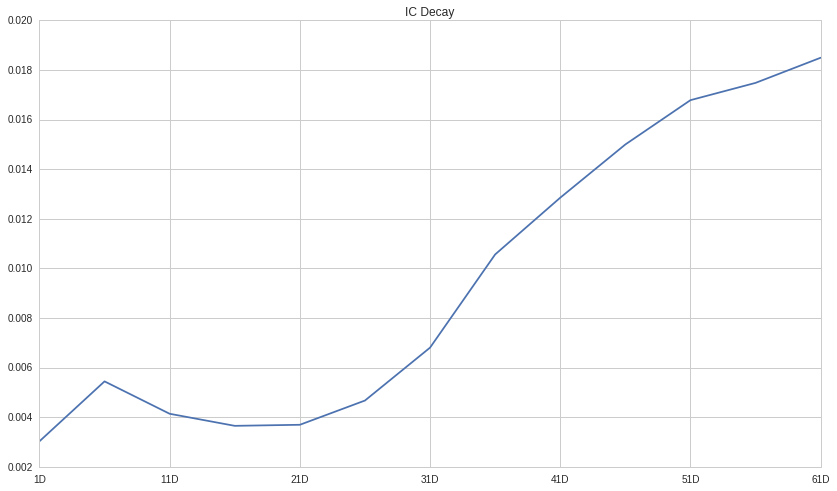

In [11]:
longest_look_forward_period = 63 # week = 5, month = 21, quarter = 63, year = 252
range_step = 5

merged_data = get_clean_factor_and_forward_returns(
    factor = factor_data['factor_to_analyze'],
    prices = pricing_data,
    periods = range(1, longest_look_forward_period, range_step)
)

mean_information_coefficient(merged_data).plot(title="IC Decay")

## Create Group Neutral Tear Sheets

Dropped 2.2% entries from factor data: 2.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Information Analysis


,1D,5D,10D
IC Mean,0.002,0.005,0.006
IC Std.,0.066,0.066,0.065
Risk-Adjusted IC,0.032,0.071,0.084
t-stat(IC),0.706,1.564,1.872
p-value(IC),0.480,0.118,0.062
IC Skew,-0.018,-0.178,-0.271
IC Kurtosis,-0.177,0.000,0.153


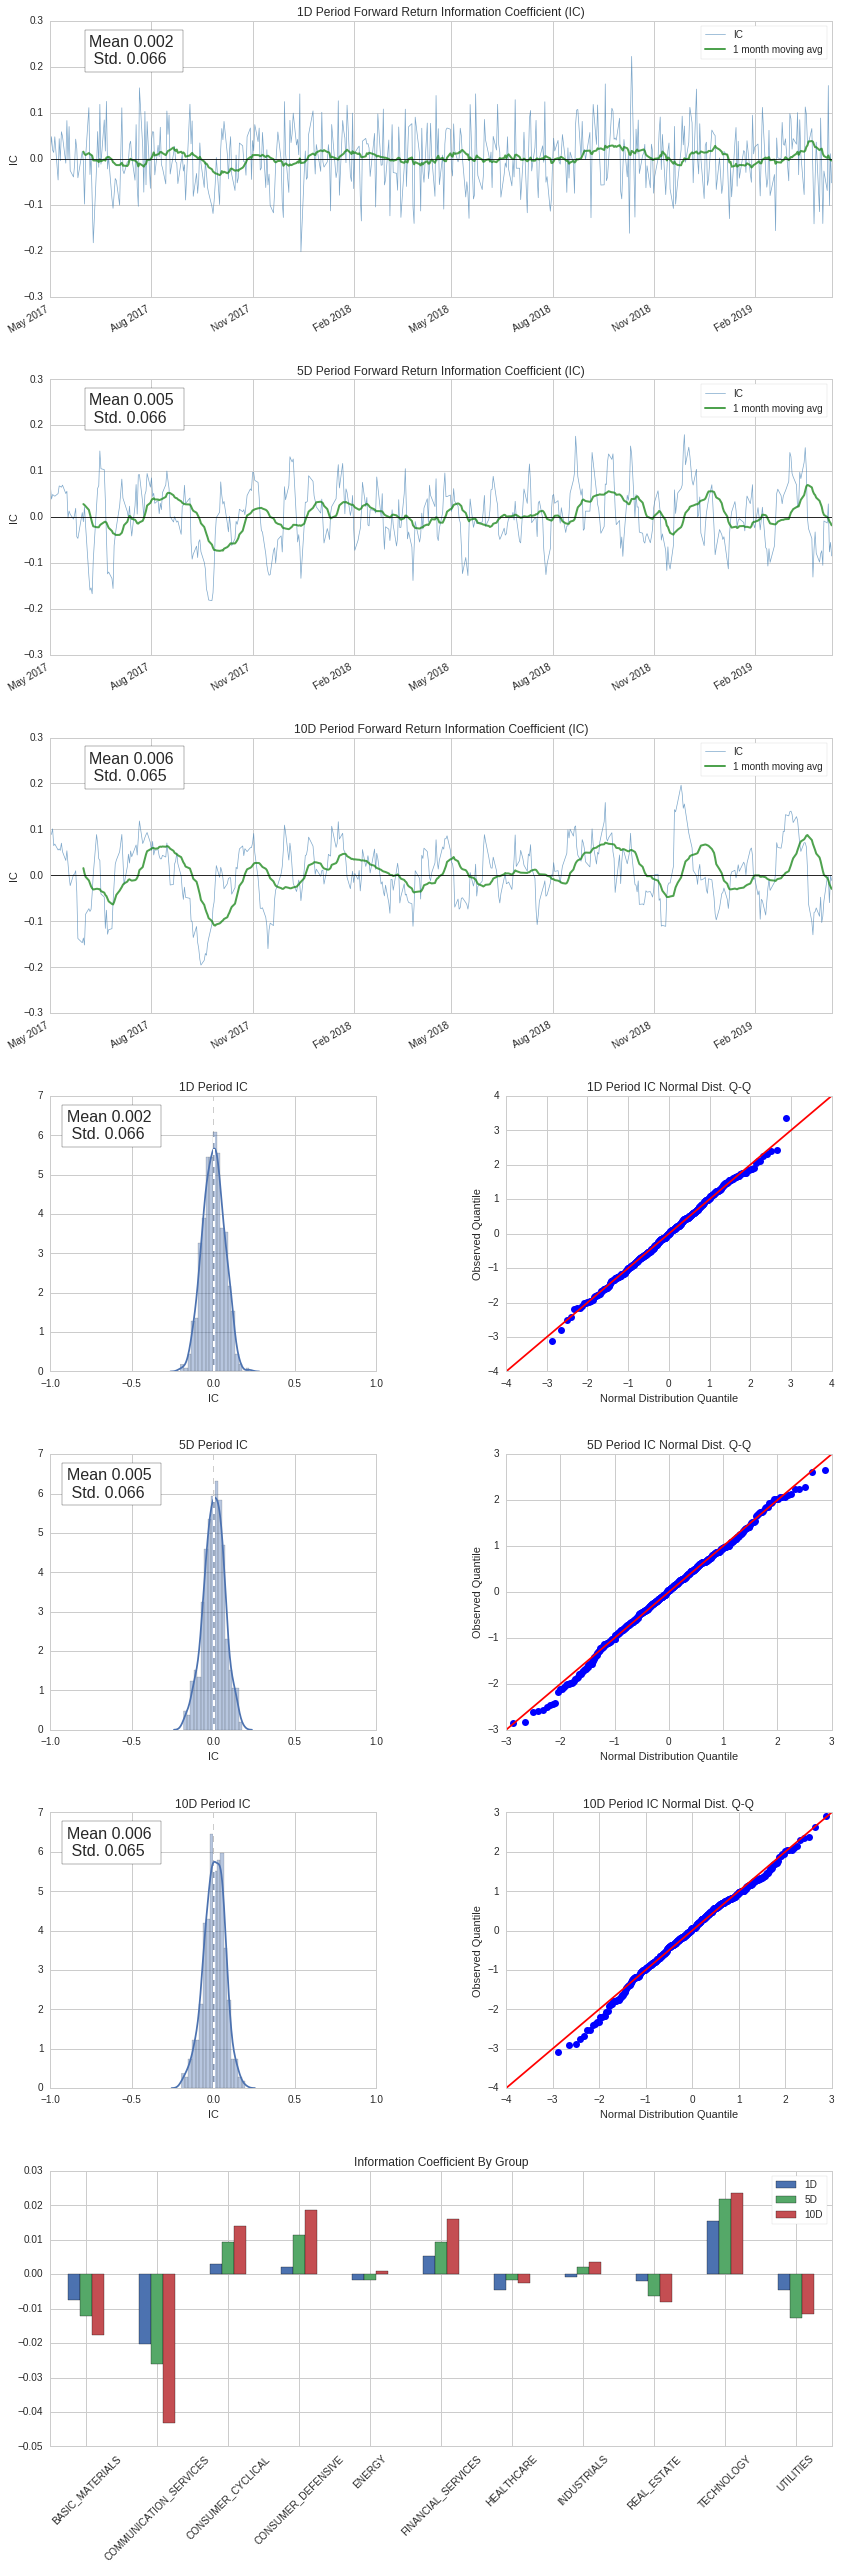

Returns Analysis


,1D,5D,10D
Ann. alpha,-0.010,-0.005,-0.000
beta,0.025,0.007,-0.008
Mean Period Wise Return Top Quantile (bps),0.631,0.584,0.573
Mean Period Wise Return Bottom Quantile (bps),-0.653,-0.840,-0.746
Mean Period Wise Spread (bps),1.284,1.419,1.314


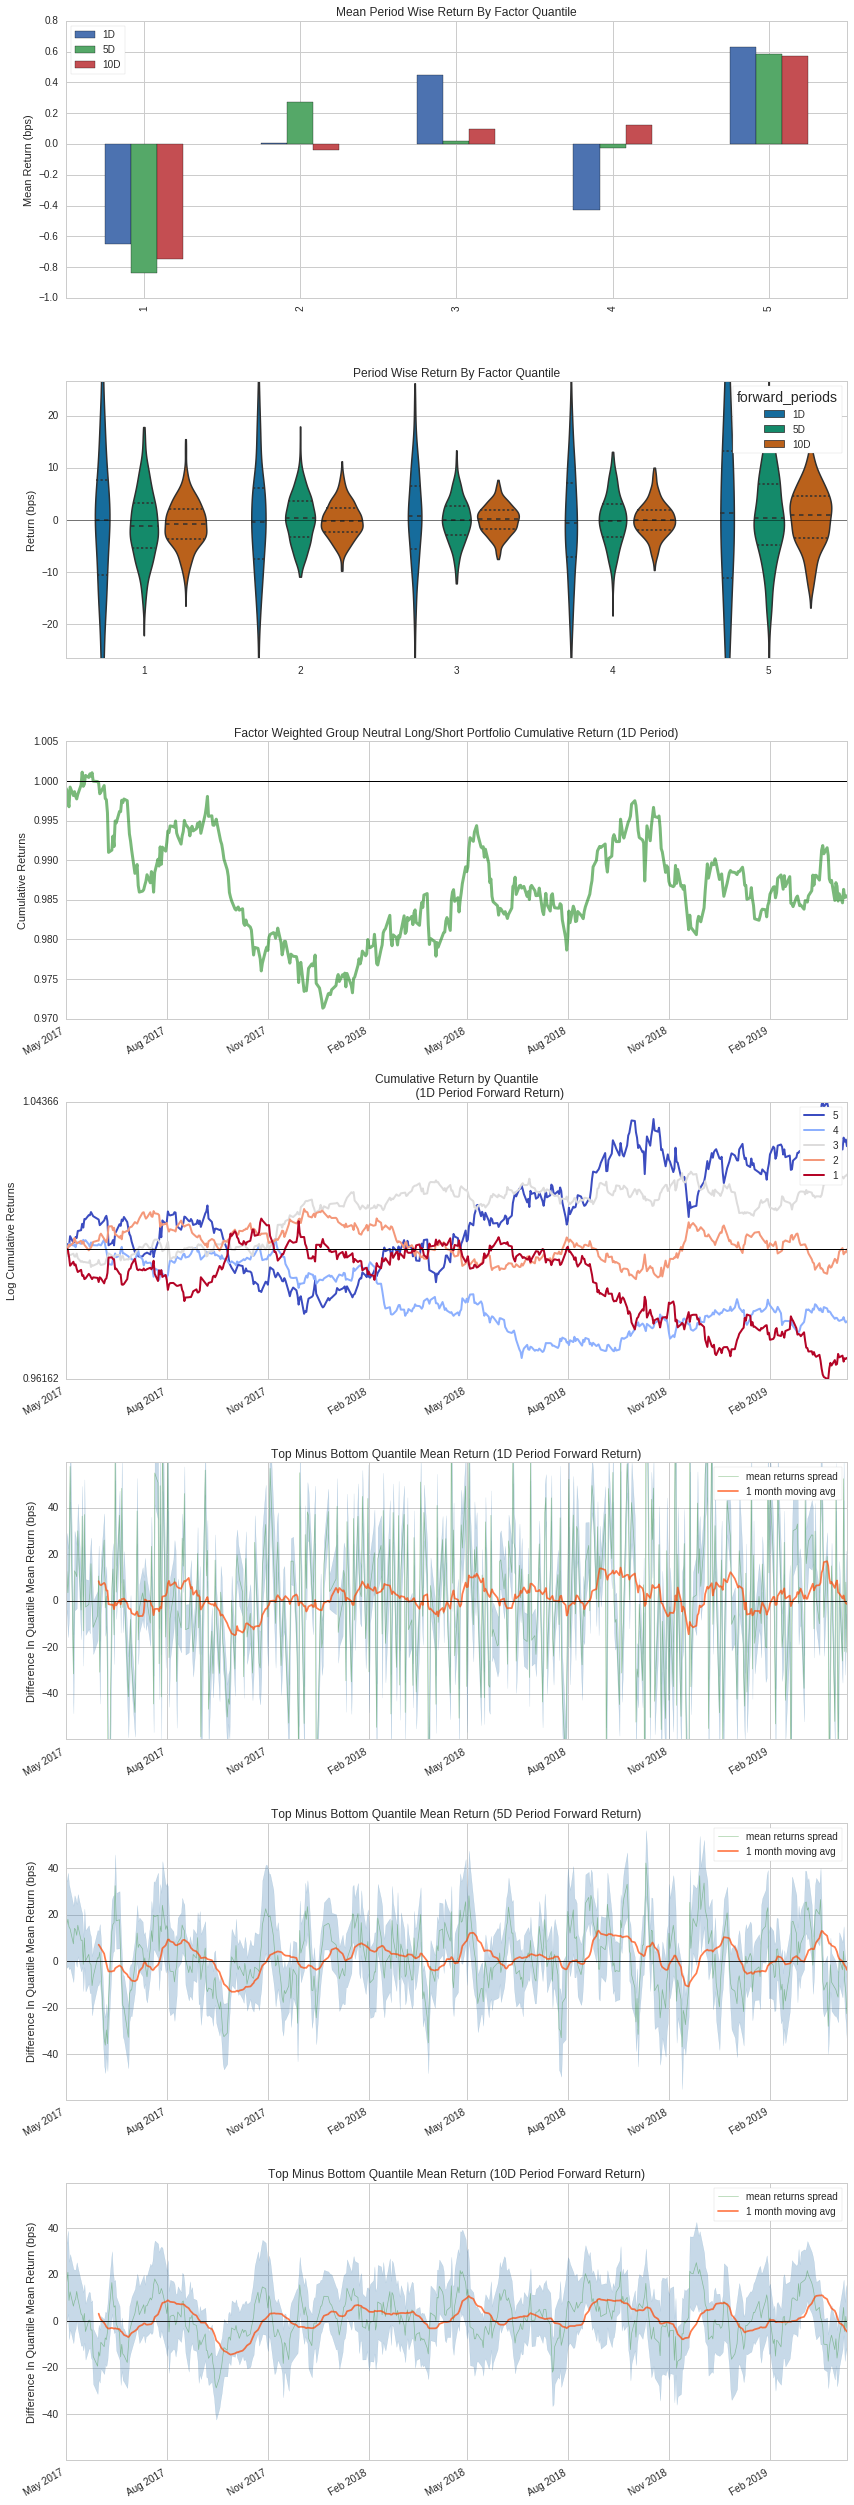

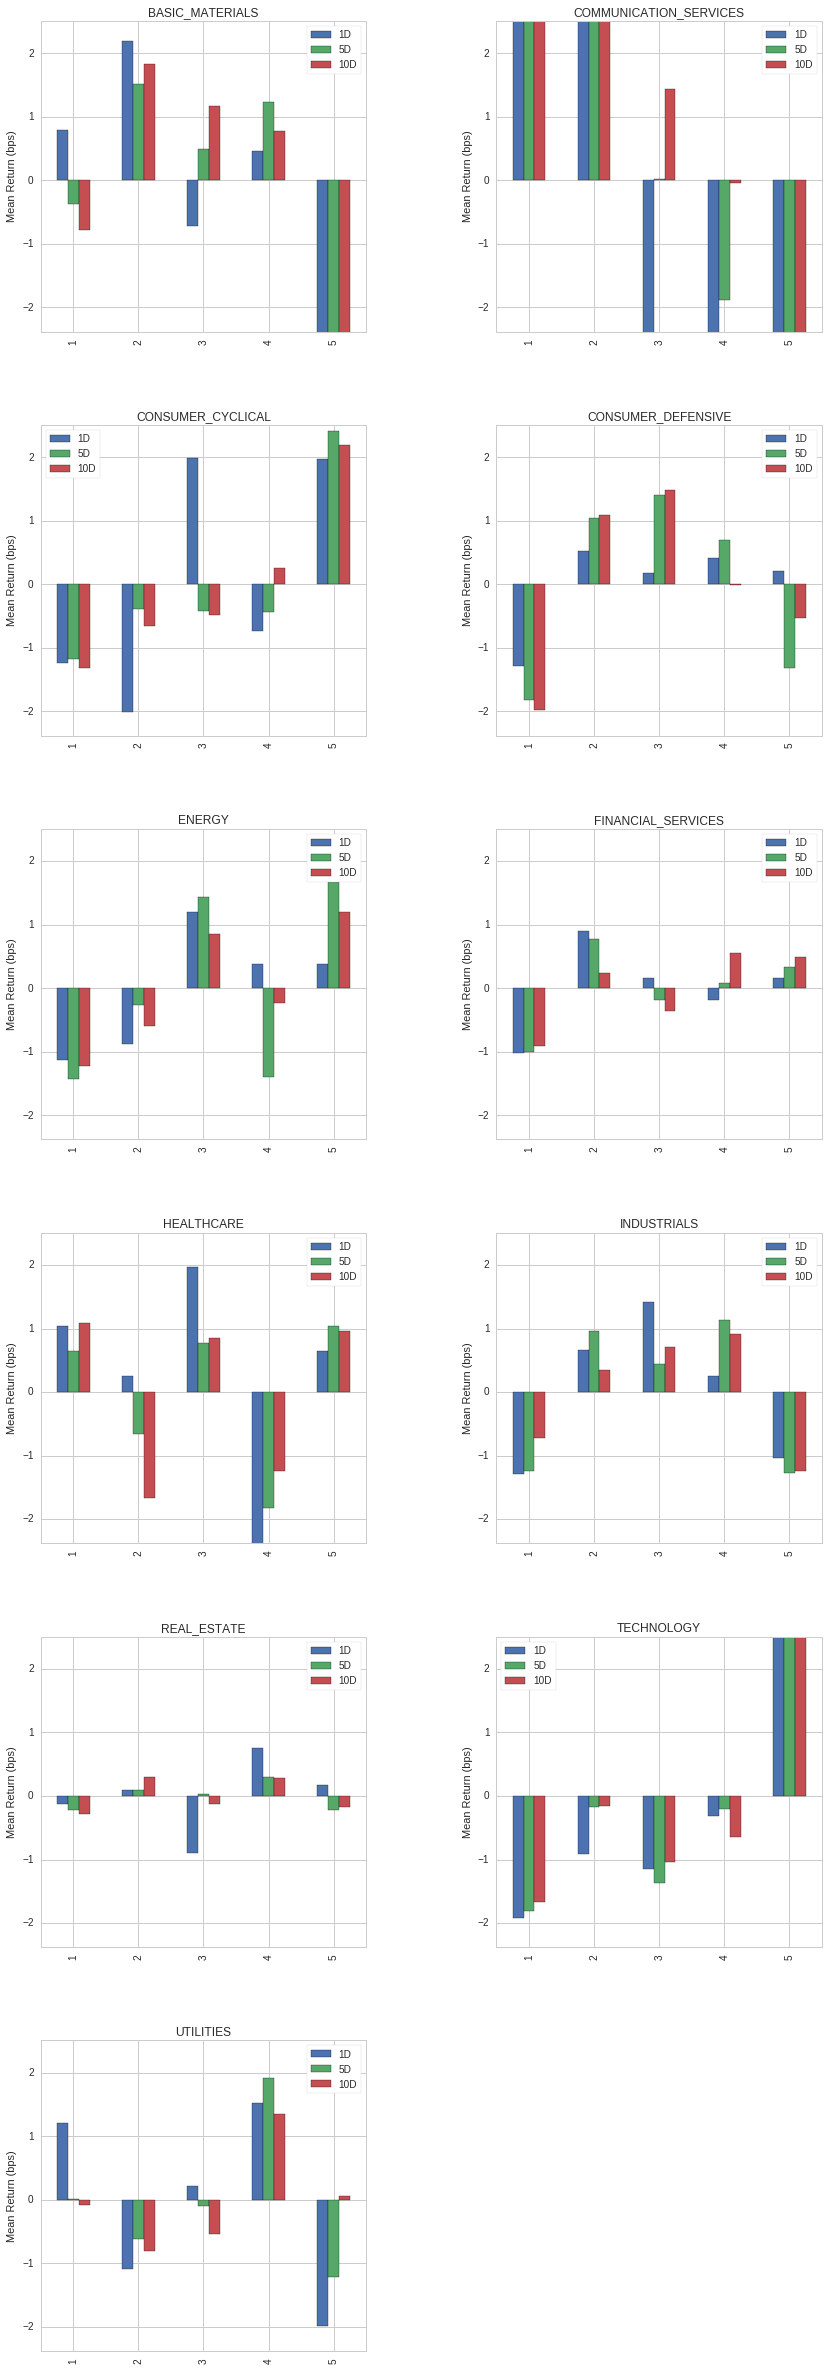

In [12]:
sector_labels, sector_labels[-1] = dict(Sector.SECTOR_NAMES), "Unknown"

merged_data = get_clean_factor_and_forward_returns(
    factor = factor_data['factor_to_analyze'],
    prices = pricing_data,
    groupby = factor_data['sector'],
    groupby_labels = sector_labels,
    binning_by_group = True,
    periods = (1,5,10)
)

create_information_tear_sheet(merged_data, by_group=True, group_neutral=True)
create_returns_tear_sheet(merged_data, by_group=True, group_neutral=True)